In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Wolff algorythm


In [144]:
def Initial (L): #Initial random state 
    
    M = np.random.randint ( 2 , size = ( L , L ) )
    
    return 2*M-1 

def Neighbours (Indices, L): #The function which detects neighbours for a given spin on the square lattice with periodic b.c.
    
    i = Indices[0]
    j = Indices[1]
    
    return [ [(i+1)%L,j] , [(i-1)%L,j] , [i,(j+1)%L] , [i,(j-1)%L] ]

def Energy (State, J, L, T, h): #The function which calculates energy for a given system 
    
    E = 0
    
    for i in range (L):
        for j in range (L):
            
            E += -J * State [i , j] * ( State [(i+1)%L , j] + State [(i-1)%L , j] + State [i , (j+1)%L] + State [i , (j-1)%L] ) - h * State[i,j]
            
    return E/4


def Wolff(L, T, J, steps): #This algorythm works both for FM and AFM cases, because the only difference is the cluster structure
    
    state = Initial (L)
    
    p  = 1.0 - np.exp(-2*np.abs(J) / T) 
    
    for step in range(steps):
        
        i = np.random.randint (L)
        j = np.random.randint (L)
        
        cluster = [[i,j]]
        
        for s in cluster:
            
            i = s[0]
            j = s[1]
            
            accepted = []
            
            for n in Neighbours(s, L):
                 
                if state[n[0],n[1]] == np.sign(J)*state[i,j] and n not in cluster and random.random()<p:  #AFM modification here
                    
                    accepted.append(n)
                    
            cluster += accepted        
        
        for s in cluster:
            
            state[s[0], s[1]] *= -1

    return state   

def AbsMeanMagn(state, L): #calculates the abs of mean magnetization value per site
    
    M = np.sum(state) / L**2
    
    return np.abs(M)

Note that this algorythm is fine both for FM ($J>0$) and AFM ($J<0$) cases. The only difference between them is what we call a "cluster". In FM case a cluster is a collection of spins, looking at the same side, and in AFM case it is a collection of spins building a "chess" structure. So, the only modification we need for AFM is $\text{sgn}J$ in the condition of adding a single spin to the cluster. 

We can easily build typical high- and low-temperature configurations:

In [3]:
HighTStateFM = Wolff(15, 10, 1, 10**3)
LowTStateFM = Wolff(15, 0.1, 1, 10**3)

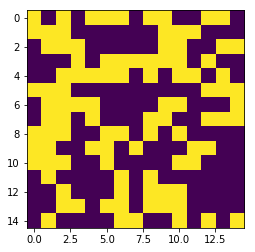

In [4]:
plt.imshow( HighTStateFM )

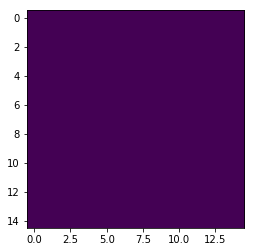

In [5]:
plt.imshow( LowTStateFM )

And they provide exactly the picture we expected. Now we can plot magnetization as a function of temperature:

In [6]:
L = 30

Tems = np.linspace ( 0.01, 15, 100 ) #Temperature scale

Magns = list ( AbsMeanMagn( Wolff(L, t, 1, 10**3) , L ) for t in Tems )

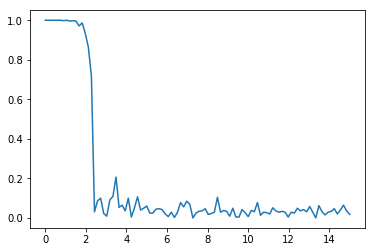

In [7]:
plt.plot( Tems , Magns )

Which also coincides with our expectations. Moreover, as we can see on the graph, the critical temperature $T_c\sim2.2$, and the analytical result is $T_c=2/\ln(1+\sqrt{2})\approx 2.26$.  This result is also fine, because our plot step is $0.1499$. We could increase $L$ in order to calculate $T_c$ more presicely, but it is already clear, that it coincides with analytical one, and I don't want my PC to die.  

For AFM case the high- and low-temperature configurations are :

In [210]:
HighTStateAFM = Wolff(15, 100, -1, 10**3)
LowTStateAFM = Wolff(15, 0.001, -1, 10**3)

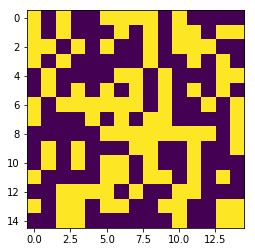

In [206]:
plt.imshow( HighTStateAFM )

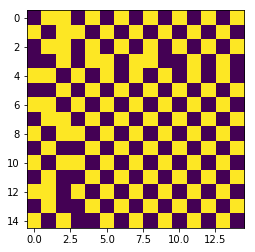

In [211]:
plt.imshow( LowTStateAFM )

We see, that the result is not perfect, due to the appearence of domain walls. But anyway it provides us with expected "chess" structure. It is a good sign, the algorythm works.

If we add an external magnetic field in our problem, it is not really clear how to build a cluster such, that our algorythm will possess detailed belance condition. The alternative option is to modify the algorythm in "Metropolis" style: we will accept the clusster with a certain probability. As in Metropolis algorythm, $p_{add}=1$ if $\Delta E<0$ and $p_{add}=e^{-\Delta E /t}$ otherwise.

In [195]:
def WolffSource(L, T, J, H, steps):
    
    state = Initial (L)
    
    p  = 1.0 - np.exp(-2*np.abs(J) / T) 
    
    for step in range(steps):
        
        i = np.random.randint (L)
        j = np.random.randint (L)
        
        cluster = [[i,j]]
        
        
        
        for s in cluster:
            
            i = s[0]
            j = s[1]
            
            accepted = []
            
            for n in Neighbours(s, L):
                 
                if state[n[0],n[1]] == np.sign(J)*state[i,j] and n not in cluster and random.random()<p:  #AFM modification here
                    
                    accepted.append(n)
                    
            cluster += accepted 
           
        CheckState = np.copy( state )    
        
        for s in cluster:
            
            CheckState[s[0], s[1]] *= -1
            
        dE = (Energy(CheckState, J, L, T, H) - Energy(state, J, L, T, H))
            
        if dE < 0:
            
            state = np.copy ( CheckState )
            
        if dE > 0 and random.random() < np.exp(-dE/T):
            
            state = np.copy ( CheckState )

    return state   

We can now check what happens with AFM system on big temperatures in the presence of strong $h=1000$ magnetic field:

In [157]:
AFMstate = WolffSource(15, 100, -1, 1000 , 10**3) #L=15, T=100, J=-1, H=1000

0.98222222222222222

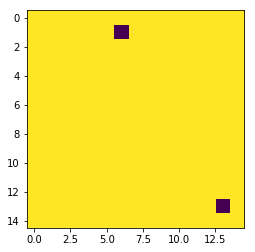

In [158]:
plt.imshow( AFMstate )
AbsMeanMagn( AFMstate , 15)

As expected, the spins are mostly aligned along the field direction except for two guys who gave up to the thermal fluctuations (here we have high $T=100$). So, the simulation probably works. Now let us draw the dependence $m(T)$ for different temperatures and lattice sizes. First of all in strong magnetic field:

In [219]:
L = 30

Tems1 = np.linspace ( 0.01, 10, 40 ) 

Magns1 = list ( AbsMeanMagn( WolffSource(30, t, -1, 100, 10**3) , 30 ) for t in Tems1 )

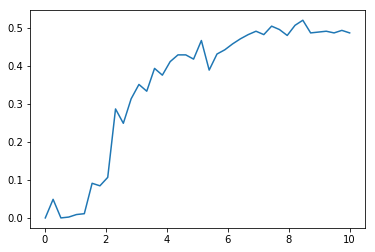

In [220]:
plt.plot( Tems1 , Magns1 )#Temperature range from 0.01 to 10, L = 30, H = 100

And for the long-scale picture:

In [223]:
Tems3 = np.linspace ( 0.01, 100, 40 ) 

Magns3 = list ( AbsMeanMagn( WolffSource(30, t, -1, 100, 10**3) , 30 ) for t in Tems3 )

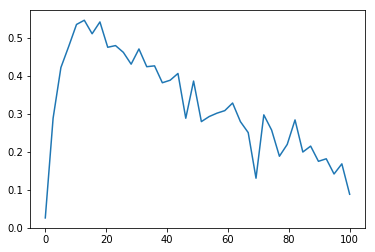

In [224]:
plt.plot( Tems3 , Magns3 ) #Temperature range from 0.01 to 100, L = 30, H = 100

What we see is a more or less expected behaviour. In the beginning our system sits at AFM-ordered state (chess structure), and the magnetic field with temperature want the same thing: to destroy this order. When the order is destroied, strong magnetic field alligns most of the spins in its direction. Then, temperature increases and impacts FM-order iduced by the field more and more, until the moment when it's gone and the mean magnetization value is zero.

Now we can plot the same graphs for $H=0.5$, as we are asked in the problem:

In [226]:
Tems4 = np.linspace ( 0.01, 100, 40 ) 

Magns4 = list ( AbsMeanMagn( WolffSource(15, t, -1, 0.5, 10**3) , 15 ) for t in Tems4 )

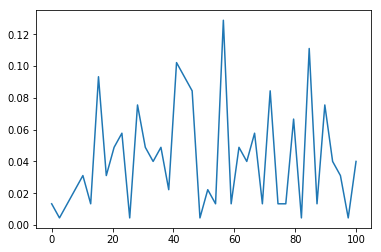

In [227]:
plt.plot( Tems4 , Magns4 ) #Temperature range from 0.01 to 10, L=30, H = 0.5

Here, however, we can't see any meaningful behavior. The field is not strong, and that's why we see only some fluctuations around zero-value. Let us try to take an average of ten realizations:

In [233]:
Magns5 = np.zeros(40)

for step in range(10):
    
    ms = list ( AbsMeanMagn( WolffSource(15, t, -1, 0.5, 10**3) , 15 ) for t in Tems4 )
    
    for i in range(40):
        
        Magns5[i] += ms[i]/10
    

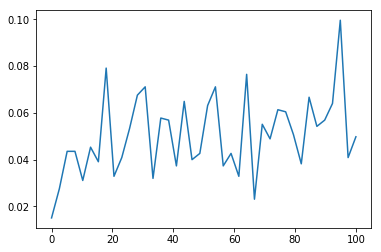

In [235]:
plt.plot( Tems4 , Magns5 ) 

And here also nothing changes. We can't see any "critical" behavior.

What I think is following: in order to see a phase transition from AFM to FM state we have to get some critical field value $H_{c}$. It follows from the fact that at $H=0$ our model (in the exact solution) has negative $T_c\sim J$. Probably, $H=0.5$ is not enough to get the critical temperature. The same argument can be summoned for answering the p.5: if at $H=0$ we have $T_c<0$ and at $H>>0$ we have $T_c>0$, then $T_c$ must grow with growing $H$.

On the other hand, I am probably wrong just because we are asked to find critical temperature, and I can't see any critical behavior at all... I would be very thankful for some comments, maybe my code is just wrong.